In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm


### Define the data_directory of preprocessed data

In [2]:
data_directory = "C:/Users/kwokp/OneDrive/Desktop/Study/zzz_application project/Final/data_after_preprocessing.csv"

### We devide the data into 3 groups:
* Group 1: full data
* Group 2: data with four large categories which have more than 1000 companies each
* Group 3: seven categories of data, number of companies in each category is same but small

### In the function selectGroup, giving 1, 2 or 3 as input parameter to selet the relevant data for experiment

In [3]:
# read the data from directory, then select the group 
# of data we want to process.
def selectGroup(directory, group_nr):
    data = pd.read_csv(directory, sep='\t')
    if group_nr == 1:
        return data
    if group_nr == 2:
        df_healthcare_group=data[data['Category'] == 'HEALTHCARE GROUP'].sample(n=1041,replace=False)
        df_business_financial_services=data[data['Category'] == 'BUSINESS & FINANCIAL SERVICES'].sample(n=1041,replace=False)
        df_consumer_service_group=data[data['Category'] == 'CONSUMER SERVICES GROUP'].sample(n=1041,replace=False)
        df_information_technology_group=data[data['Category'] == 'INFORMATION TECHNOLOGY GROUP'].sample(n=1041,replace=False)
        df_clean = pd.concat([df_healthcare_group, df_business_financial_services,df_consumer_service_group,df_information_technology_group])
        return df_clean.sample(frac=1)
    if group_nr == 3:
        df_healthcare_group=data[data['Category'] == 'HEALTHCARE GROUP'].sample(n=219,replace=False)
        df_business_financial_services=data[data['Category'] == 'BUSINESS & FINANCIAL SERVICES'].sample(n=219,replace=False)
        df_consumer_service_group=data[data['Category'] == 'CONSUMER SERVICES GROUP'].sample(n=219,replace=False)
        df_information_technology_group=data[data['Category'] == 'INFORMATION TECHNOLOGY GROUP'].sample(n=219,replace=False)
        df_industry_goods=data[data['Category'] == 'INDUSTRIAL GOODS & MATERIALS GROUP'].sample(n=219,replace=False)
        df_consumer_goods=data[data['Category'] == 'CONSUMER GOODS GROUP'].sample(n=219,replace=False)
        df_energy=data[data['Category'] == 'ENERGY & UTILITIES GROUP'].sample(n=219,replace=False)
        df_clean = pd.concat([df_healthcare_group, df_business_financial_services,df_consumer_service_group,df_information_technology_group,df_industry_goods,df_consumer_goods,df_energy])
        return df_clean.sample(frac=1)

In [4]:
# use tf-idf methode to generate scores for each company
def tf_idf_func(df_document, max_features):
    feature_extraction = TfidfVectorizer(max_features = max_features, stop_words = 'english')
    score_matrix = feature_extraction.fit_transform(df_document.values)
    return score_matrix, feature_extraction

In [5]:
# get the top_n words
def get_top_keywords(scores_matrix, clusters, labels, n_terms):
    df = pd.DataFrame(scores_matrix.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))    

# get the top_n words with highest tf-idf scores in each category, and count the word occurence
def get_top_keywords_with_frequence(Top_N, score_matrix, df_data, feature_extraction):
    df = pd.DataFrame(score_matrix.todense()) #read tf-idf score-matrix, each line is vectors for each company, each column matches each word
    df['Category'] = df_data['Category'] #assign the category for each line(company) in score-matrix
    dfg = df.groupby(['Category']).mean() #calculate the mean score of each word in each cateogry

    labels = feature_extraction.get_feature_names()

    categories = df_data['Category'].unique()
    col_names = ['Category', 'Top_N', 'Score']
    df_top = pd.DataFrame(columns = col_names)

    Dict = {}

    for i,r in dfg.iterrows(): #i-index(category), r-row, iterate the average score matrix of each category
        category = i 
        top_series = np.argsort(r)[-Top_N:]#find the location of top_n words
        label_series = top_series.apply(lambda x: labels[x]) #find top_n words with best scores in each category
        top_scores = np.sort(r)[-Top_N:] #find the scores corresponding with top_n words
        df_each = pd.DataFrame({'Category':category,'Top_N':label_series,'Score':top_scores})
        df_top = df_top.append(df_each, ignore_index = True)
        for key in label_series: #count how often each word appears in the top_n
            if key in Dict:
                Dict[key] = Dict[key]+1
            else:
                Dict[key] = 1
    
    df_reshape = df_top.pivot(index='Top_N', columns='Category') #reformat the top-n score matrix
    sortedDict = sorted(Dict.items(), key=lambda x: x[1]) #sort the dictionary
    
    return sortedDict

In [6]:
# convert the input of the top_n words with their occurence in each category, to a list of stopwords, 
# if the occurence is larger than the given occurence
def get_word_occurence_stopwordslist(max_occurence, dict_list):
    word = []
    occurence = []
    frequent_stopwords = []
    for key, value in dict_list:
        word.append(key)
        occurence.append(value)
        if value > max_occurence: # if the occurence is larger than the given occurence
            frequent_stopwords.append(key) # store to a list of stopwords
    return word, occurence, frequent_stopwords

In [7]:
#remove the words from a sentence, which is in the stopwords
def remove_frequent_stopwords(sentences, frequent_stopwords):
    splitted_string = sentences.split()
    remove_stopwords = [w for w in splitted_string if not w in frequent_stopwords]
    return ' '.join(remove_stopwords)

#remove the words from the website content, which is in the stopwords
#update the tf-idf score matrix for the whole corpus
def remove_frequent_stopwords_and_get_updated_tfidfscore(data, feature_extraction, top_n, frequent_stopwords):
    df_update = data['clean'].apply(lambda x: remove_frequent_stopwords(x, frequent_stopwords))
    score_matrix_update = feature_extraction.fit_transform(df_update.values)
    return score_matrix_update

### List Occurence of words in Top 50 Keywords in Categories

In [8]:
#visualize top_n words with occurence 
def visulaze_topwords_occurence(top_n, word_list, occurence_list):
    objects = word_list
    y_pos = np.arange(len(word_list))
    performance = occurence_list
    plt.figure(figsize=(10,24))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Occurence')
    plt.title('Occurence of words in Top ' + str(top_n) + ' Keywords in categories')
    plt.show()

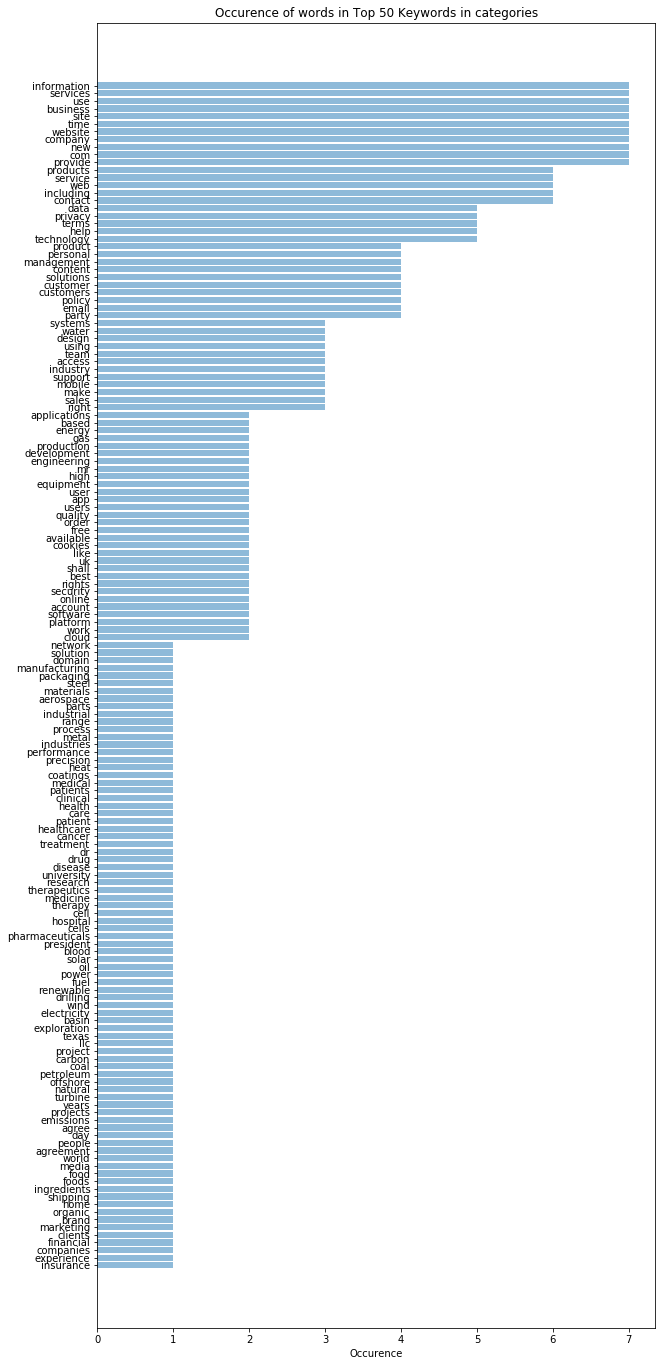

In [9]:
data = selectGroup(data_directory, 1)
score_matrix, feature_extraction = tf_idf_func(data['clean'], 8000)
sortedDict = get_top_keywords_with_frequence(50, score_matrix, data, feature_extraction)
word, occurence, _ = get_word_occurence_stopwordslist(1, sortedDict)
visulaze_topwords_occurence(50, word, occurence)

### We remove the redundunt words which appears in multiple category . Main steps are as follows:
1. select the group of data to do the test
2. generate TF-IDF score matrix
3. get the top 50 words in each category
4. find the words which appears in more than one category's top-50 words, set them as stopwords
5. remove these stopwords and update the tf-idf score matrix
6. count and calculate the word occurences in each company's website
7. plot the number of valid words in each website
8. remove the website which has less than 200 words

### We may notice there are quite a few companies which has less than 200 words. These websites could be useless. And the category distrubtion after processing is shown as the reuslt of the cell.


Cluster BUSINESS & FINANCIAL SERVICES
learn,agreement,need,insurance,media,experience,financial,companies,clients,marketing

Cluster CONSUMER GOODS GROUP
read,sites,address,brand,organic,home,shipping,ingredients,foods,food

Cluster CONSUMER SERVICES GROUP
experience,media,sites,world,address,parties,people,day,agreement,agree

Cluster ENERGY & UTILITIES GROUP
llc,basin,electricity,wind,drilling,renewable,fuel,power,oil,solar

Cluster HEALTHCARE GROUP
dr,treatment,cancer,healthcare,patient,care,health,clinical,patients,medical

Cluster INDUSTRIAL GOODS & MATERIALS GROUP
industries,process,range,industrial,parts,aerospace,materials,steel,packaging,manufacturing

Cluster INFORMATION TECHNOLOGY GROUP
application,world,performance,experience,need,learn,enterprise,domain,solution,network


INFORMATION TECHNOLOGY GROUP          1503
BUSINESS & FINANCIAL SERVICES         1333
CONSUMER SERVICES GROUP                956
HEALTHCARE GROUP                       832
INDUSTRIAL GOODS & MATERIALS GROUP     391
CONSUMER GOODS GROUP                   341
ENERGY & UTILITIES GROUP               175
Name: Category, dtype: int64

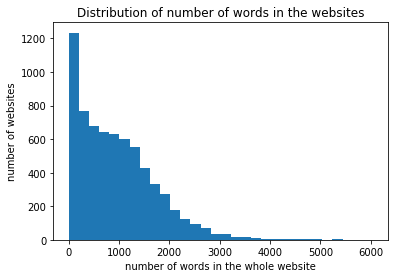

In [10]:
#get the data, remove the frequent words which appear in more than one category, and update the tf-idf score matrix
data = selectGroup(data_directory, 1)
score_matrix, feature_extraction = tf_idf_func(data['clean'], 8000)
sortedDict = get_top_keywords_with_frequence(50, score_matrix, data, feature_extraction)
_, _, frequent_stopwords = get_word_occurence_stopwordslist(1, sortedDict)
score_matrix_update = remove_frequent_stopwords_and_get_updated_tfidfscore(data, feature_extraction, 10, frequent_stopwords)

#show the top keywords of the rest words after removing the frequent words which appear in more than one category
get_top_keywords(score_matrix_update, data['Category'].values, feature_extraction.get_feature_names(), 10)

# count the non-zero words from updated tf-idf score matrix and display the non-zero word count in each company website
score_value = score_matrix_update.todense()
website_word_count=np.asarray(np.count_nonzero(score_value, axis=1)).reshape(-1)
plt.hist(website_word_count, bins = 30)
plt.xlabel('number of words in the whole website')
plt.ylabel('number of websites')
plt.title('Distribution of number of words in the websites')

df_score=pd.DataFrame(score_value)
df_score.columns=feature_extraction.get_feature_names()
df_score['Keep']=website_word_count>200
df_score['Category'] = data['Category'].reset_index(drop=True)
df_score_valid = df_score[df_score['Keep']]
df_score_valid['Category'].value_counts()

### Split the data 80% for training and 20% for testing

In [11]:
df_final = df_score_valid[df_score_valid.columns.difference(['Keep', 'Category'])] #remove columns'Keep' and 'Category'

df_category = df_score_valid['Category'].reset_index(drop=True)

msk = np.random.rand(len(df_final)) < 0.8
train_x = np.nan_to_num(df_final[msk])
test_x = np.nan_to_num(df_final[~msk])
train_y = df_category[msk].to_numpy()
test_y = df_category[~msk].to_numpy()

### Perform Linear SVM

start svm
[[145   4  24   2   3   5  66]
 [  4  28  16   0   3   7   5]
 [ 24   7 115   1   8   2  30]
 [  6   0   0  21   0   2   3]
 [  8   5   6   1 135   4  15]
 [ 15   3   6   3   1  45   9]
 [ 68   4  32   1   6   9 225]]
                                    precision    recall  f1-score   support

     BUSINESS & FINANCIAL SERVICES       0.54      0.58      0.56       249
              CONSUMER GOODS GROUP       0.55      0.44      0.49        63
           CONSUMER SERVICES GROUP       0.58      0.61      0.60       187
          ENERGY & UTILITIES GROUP       0.72      0.66      0.69        32
                  HEALTHCARE GROUP       0.87      0.78      0.82       174
INDUSTRIAL GOODS & MATERIALS GROUP       0.61      0.55      0.58        82
      INFORMATION TECHNOLOGY GROUP       0.64      0.65      0.64       345

                          accuracy                           0.63      1132
                         macro avg       0.64      0.61      0.62      1132
          

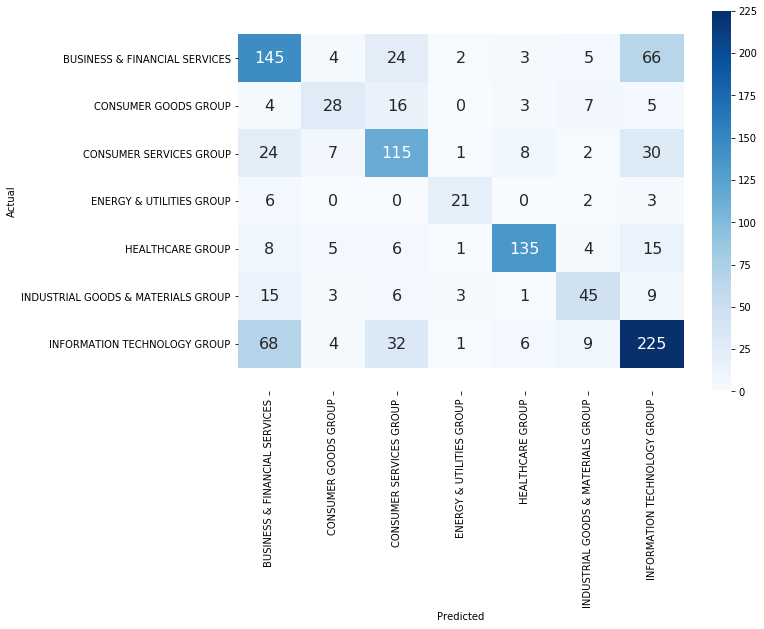

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#use svm classifier to classify TF-IDF of each website
def linear_svc_classifier(train_x, train_y, test_x, test_y):
    print("start svm")
    classifier_svm = svm.LinearSVC()
    classifier_svm.fit(train_x, train_y)
    predictions = classifier_svm.predict(test_x)
     
    print(confusion_matrix(test_y, predictions))
    print(classification_report(test_y, predictions))
    print(accuracy_score(test_y, predictions))
    
    array = confusion_matrix(test_y, predictions)
    
  
    y_true = ["BUSINESS & FINANCIAL SERVICES", "CONSUMER GOODS GROUP", "CONSUMER SERVICES GROUP", "ENERGY & UTILITIES GROUP","HEALTHCARE GROUP", "INDUSTRIAL GOODS & MATERIALS GROUP","INFORMATION TECHNOLOGY GROUP"]
 
    y_pred = y_true
    df_cm = pd.DataFrame(array, y_true, y_pred)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    #sn.set(font_scale=1.4)#for label size
    ax=sn.heatmap(df_cm, cmap="Blues", annot=True, fmt='d',annot_kws={"size": 16})# font size
    bottom, top=ax.get_ylim()
    ax.set_ylim(bottom+0.5, top-0.5)
    ax.tick_params(labelsize=10) 
    plt.show()
    
    return confusion_matrix(test_y, predictions),predictions

confusion_matrix, predictions = linear_svc_classifier(train_x, train_y, test_x, test_y)

### Perform KNN with 5 Neighbours

start knn
[[153   7  22   4   5   4  54]
 [  8  25  19   1   3   2   5]
 [ 33  17  89   1  12   2  33]
 [ 10   1   0  16   2   0   3]
 [ 18   5   8   0 133   3   7]
 [ 21   4   4   4   2  34  13]
 [106   6  40   2   8   7 176]]
                                    precision    recall  f1-score   support

     BUSINESS & FINANCIAL SERVICES       0.44      0.61      0.51       249
              CONSUMER GOODS GROUP       0.38      0.40      0.39        63
           CONSUMER SERVICES GROUP       0.49      0.48      0.48       187
          ENERGY & UTILITIES GROUP       0.57      0.50      0.53        32
                  HEALTHCARE GROUP       0.81      0.76      0.78       174
INDUSTRIAL GOODS & MATERIALS GROUP       0.65      0.41      0.51        82
      INFORMATION TECHNOLOGY GROUP       0.60      0.51      0.55       345

                          accuracy                           0.55      1132
                         macro avg       0.56      0.53      0.54      1132
          

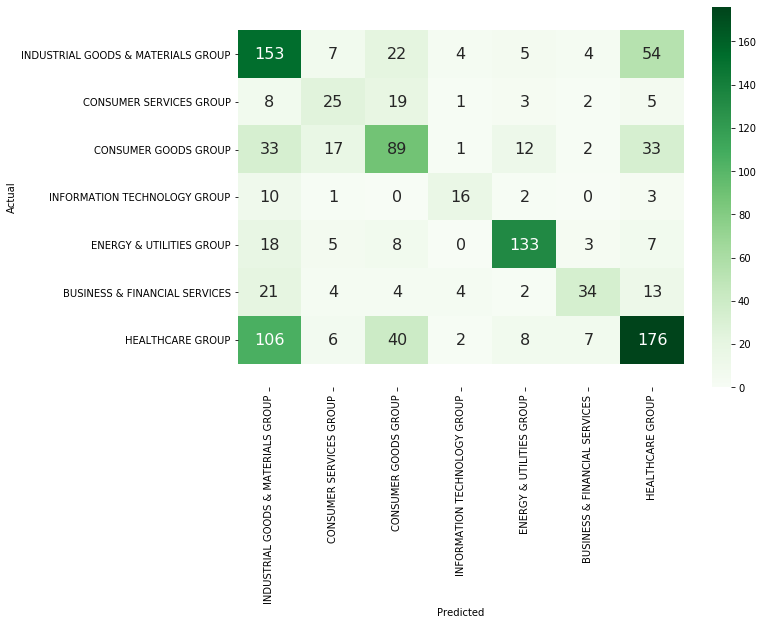

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#use knn classifier to classify TF-IDF of each website
def knn_classifier(x_train, y_train, x_test, y_test):
    print("start knn")
    modelknn = KNeighborsClassifier(n_neighbors=5)
    modelknn.fit(x_train, y_train)
    predictions = modelknn.predict(x_test)

    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))
    print(accuracy_score(y_test, predictions))
    
    array = confusion_matrix(y_test, predictions)
    
    y_true = ["INDUSTRIAL GOODS & MATERIALS GROUP", "CONSUMER SERVICES GROUP","CONSUMER GOODS GROUP","INFORMATION TECHNOLOGY GROUP","ENERGY & UTILITIES GROUP","BUSINESS & FINANCIAL SERVICES", "HEALTHCARE GROUP"]
             
    y_pred = y_true
    df_cm = pd.DataFrame(array, y_true, y_pred)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    #sn.set(font_scale=1.4)#for label size
    ax=sn.heatmap(df_cm, cmap="Greens", annot=True, fmt='d',annot_kws={"size": 16})# font size
    bottom, top=ax.get_ylim()
    ax.set_ylim(bottom+0.5, top-0.5)
    ax.tick_params(labelsize=10) 
    plt.show()

    return confusion_matrix(test_y, predictions),predictions

confusion_matrix, predictions = knn_classifier(train_x, train_y, test_x, test_y)

### Perform K means and Plot SSE, PCA and TSNE

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters

Cluster 0
devices,storage,application,performance,networks,infrastructure,enterprise,solution,wireless,network

Cluster 1
reserved,click,read,learn,world,copyright,need,home,wordpress,domain

Cluster 2
dr,healthcare,treatment,cancer,care,health,patient,medical,clinical,patients

Cluster 3
meal,day,fresh,coffee,delicious,cheese,restaurant,foods,ingredients,food

Cluster 4
http,window,archive,width,function,document,gform,jquery,px,var

Cluster 5
people,group,market,global,years,financial,companies,experience,marketing,clients

Cluster 6
address,provided,applicable,sites,websites,law,collect,parties,agree,agreement
(4, 6, 3, 1, 0, 5, 2)
The Accuracy is 0.34


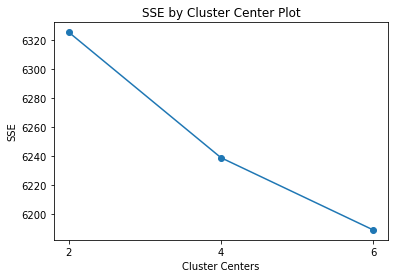

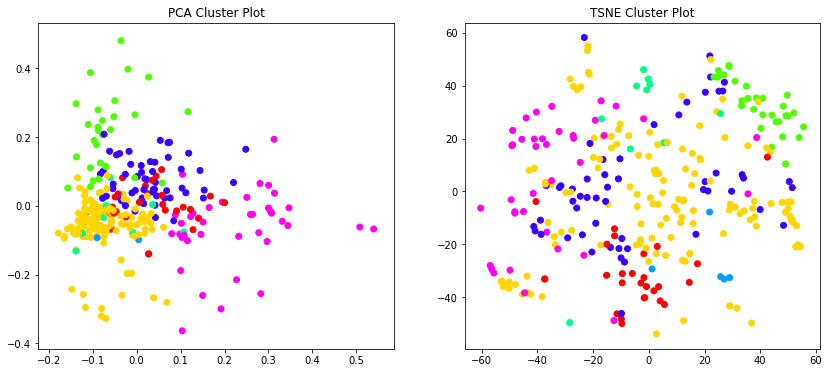

In [14]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import itertools

#Find the optimal clusters from 2 to maximum of clusters of data group, plot respective SSE.
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=512, batch_size=1024, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

#Plot TSNE and PCA for the clusters    
def plot_tsne_pca(data, labels):
    max_label = max(labels+1)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')

#Calculate the accuracy of the clustered data and actual label     
def Calculate_accuracy(clusters, actual_label):
    count = 0
    for index, cluster in enumerate(clusters):
        if cluster==actual_label[index]:
            count+=1
    accuracy = count/len(clusters)*1.0
    return accuracy

#Assign clisters for the clustered data
def assign_clusters(original_label, permu, nr_group):
    if nr_group == 2:
        categories = ["BUSINESS & FINANCIAL SERVICES", "CONSUMER SERVICES GROUP", "HEALTHCARE GROUP", "INFORMATION TECHNOLOGY GROUP"]
    else:
        categories = ["INDUSTRIAL GOODS & MATERIALS GROUP", "CONSUMER SERVICES GROUP","CONSUMER GOODS GROUP","INFORMATION TECHNOLOGY GROUP","ENERGY & UTILITIES GROUP","BUSINESS & FINANCIAL SERVICES", "HEALTHCARE GROUP"]
    mydict=dict(zip(categories, permu))
    actual_label = np.zeros(len(original_label))
    for index, label in enumerate(original_label):
        actual_label[index] = mydict[label]
    return actual_label

#Perform Kmeans and Plot
def kmeans_classifier(score_matrix_update, nr_group):
    if nr_group == 2:
        nr_cluster = 4
    else:
        nr_cluster = 7
    find_optimal_clusters(score_matrix_update, nr_cluster)
    clusters = MiniBatchKMeans(n_clusters=nr_cluster, init_size=512, batch_size=1024, random_state=20).fit_predict(score_matrix_update)
    plot_tsne_pca(score_matrix_update, clusters)
    get_top_keywords(score_matrix_update, clusters, feature_extraction.get_feature_names(), 10)

    if nr_group == 2:
        numbers=[0,1,2,3]
    else:
        numbers = [0,1,2,3,4,5,6]
    permu = list(itertools.permutations(numbers))
    best_accuracy = 0
    for i in range(len(permu)):
        actual_label = assign_clusters(data['Category'].values, permu[i], nr_group)
        accuracy = Calculate_accuracy(clusters, actual_label)
        if best_accuracy<accuracy:
            best_accuracy=accuracy
            final_label = actual_label
            category = permu[i]
        else: 
            best_accuracy=best_accuracy

    print(category)
    #print(final_label)
    print("The Accuracy is " + str(round(best_accuracy,2)))

kmeans_classifier(score_matrix_update, 1)    